In [1]:
import pandas as pd

file_path = "agridata_csv_202110311352.csv"
df = pd.read_csv(file_path)
df.head()

,commodity_name,state,district,market,min_price,max_price,modal_price,date
0,Ajwan,Gujarat,Amreli,Amreli,63.25,79.55,79.55,2019-05-22
1,Ajwan,Gujarat,Banaskanth,Dhanera,80.05,80.05,80.05,2019-05-22
2,Ajwan,Gujarat,Jamnagar,Jamnagar,90.00,155.00,122.50,2019-05-22
3,Ajwan,Gujarat,Mehsana,Kadi,94.50,112.50,107.00,2019-05-22
4,Ajwan,Gujarat,Mehsana,Unjha,21.25,148.50,99.75,2019-05-22


Randomizing the dataset and deleting a portion of it so that the execution time is less.

In [2]:
# Shuffle the dataset to ensure randomness
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # Full shuffle

# Take a 20% sample
df_sampled = df.sample(frac=0.2, random_state=42)

# Reset index after sampling
df_sampled.reset_index(drop=True, inplace=True)

# Save the reduced dataset
df_sampled.to_csv("/content/reduced_dataset.csv", index=False)
print("✅ Reduced dataset saved successfully! Shape:", df_sampled.shape)


✅ Reduced dataset saved successfully! Shape: (16956, 8)


Loading the reduced data

In [3]:
import pandas as pd

# Load the reduced dataset
file_path = "/content/reduced_dataset.csv"
df = pd.read_csv(file_path)

# Display first few rows
df.head()


,commodity_name,state,district,market,min_price,max_price,modal_price,date
0,Grapes,Maharashtra,Pune,Pune,22.00,56.00,35.00,2019-05-22
1,Gingelly+Oil,Tamil Nadu,Villupuram,Thirukovilur,91.25,106.13,101.13,2019-06-14
2,Raddish,Himachal Pradesh,Solan,Solan(Nalagarh),9.00,12.00,10.00,2019-05-25
3,Capsicum,Himachal Pradesh,Bilaspur,Bilaspur,18.00,36.00,26.00,2019-07-03
4,Banana,Uttar Pradesh,Ballia,Ballia,27.30,28.80,28.00,2019-06-21


Removing the missing values

In [4]:
# Check for missing values
missing_summary = df.isnull().sum()
print("Missing Values:\n", missing_summary[missing_summary > 0])

# Handle missing values
for col in df.columns:
    if df[col].dtype == 'object':  # Categorical columns
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:  # Numerical columns
        df[col].fillna(df[col].median(), inplace=True)  # Median is better for price data


Missing Values:
 Series([], dtype: int64)


<ipython-input-4-49e84bd2b358>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
<ipython-input-4-49e84bd2b358>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

Removing duplicates

In [5]:
df.drop_duplicates(inplace=True)


Converting the date column into day,month,year numeric values

In [8]:
# Identify date column (change 'date' if needed)
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Extract useful date features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.dayofweek


Removing the outliers (Price Columns)

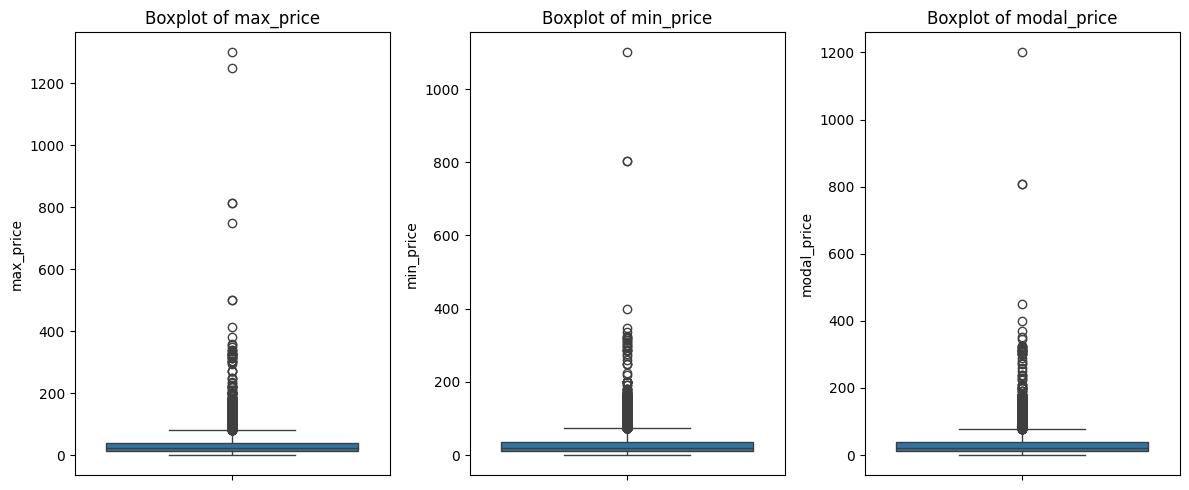

✅ Outliers removed successfully!


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

price_cols = ["max_price", "min_price", "modal_price"]

# Visualizing outliers using boxplots
plt.figure(figsize=(12,5))
for i, col in enumerate(price_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()

# Removing outliers using IQR method
for col in price_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Keep only values within the IQR range
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

print("✅ Outliers removed successfully!")


Checking if the dataset is stationary

In [10]:
from statsmodels.tsa.stattools import adfuller

price_cols = ["max_price", "min_price", "modal_price"]

for col in price_cols:
    print(f"\n🔹 Checking stationarity for {col} 🔹")

    result = adfuller(df[col].dropna())  # Drop NaN before test

    print("ADF Statistic:", result[0])
    print("p-value:", result[1])

    if result[1] < 0.05:
        print(f"✅ {col} is stationary (p-value < 0.05)")
    else:
        print(f"⚠️ {col} is NOT stationary (p-value >= 0.05), differencing may be needed")

        # Apply first-order differencing if non-stationary
        df[f"{col}_diff"] = df[col] - df[col].shift(1)



🔹 Checking stationarity for max_price 🔹
ADF Statistic: -125.55960618778496
p-value: 0.0
✅ max_price is stationary (p-value < 0.05)

🔹 Checking stationarity for min_price 🔹
ADF Statistic: -126.19350059509289
p-value: 0.0
✅ min_price is stationary (p-value < 0.05)

🔹 Checking stationarity for modal_price 🔹
ADF Statistic: -125.96842857793436
p-value: 0.0
✅ modal_price is stationary (p-value < 0.05)


*Feature Engineering (Price Trends & Rolling averages)*

In [11]:
# Create Lag Features (Previous Prices)
for col in price_cols:
    df[f"{col}_lag1"] = df[col].shift(1)  # Yesterday's price
    df[f"{col}_lag7"] = df[col].shift(7)  # Price from last week

# Create Rolling Averages
for col in price_cols:
    df[f"{col}_7day_avg"] = df[col].rolling(window=7).mean()


*Normalizing the data (scaling prices for ML Models)*

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Scale price-related features
cols_to_scale = price_cols + [f"{col}_lag1" for col in price_cols] + [f"{col}_7day_avg" for col in price_cols]
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])


*Saving the cleaned Dataset*

In [13]:
df.to_csv("/content/cleaned_dataset.csv", index=False)
print("✅ Cleaned dataset saved successfully!")


✅ Cleaned dataset saved successfully!


splitting the dataset into 3 parts, training, testing and validation sets.

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the cleaned dataset
file_path = "/content/cleaned_dataset.csv"
df = pd.read_csv(file_path)

# Ensure date column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Drop rows with NaN (due to lag features and differencing)
df.dropna(inplace=True)

# Sort data by date (IMPORTANT for time-series)
df = df.sort_values(by="date")

# Define train, validation, and test sizes
train_size = int(len(df) * 0.7)  # 70% for training
val_size = int(len(df) * 0.15)   # 15% for validation
test_size = len(df) - train_size - val_size  # 15% for testing

# Split the dataset
train = df.iloc[:train_size]
val = df.iloc[train_size:train_size+val_size]
test = df.iloc[train_size+val_size:]

# Save the splits
train.to_csv("/content/train.csv", index=False)
val.to_csv("/content/val.csv", index=False)
test.to_csv("/content/test.csv", index=False)

print("✅ Dataset split successfully!")
print(f"Train Set: {train.shape}")
print(f"Validation Set: {val.shape}")
print(f"Test Set: {test.shape}")


✅ Dataset split successfully!
Train Set: (10899, 21)
Validation Set: (2335, 21)
Test Set: (2337, 21)
